## Kaggle Titanic

In [7]:
%%bash
git add Titanic.ipynb
git commit -m 'Adding some basic code from prvious working file'
git push

[master 22bc806] Adding some basic code from prvious working file
 1 file changed, 148 insertions(+), 4 deletions(-)


To github.com:Theerit/Kaggle_Titanic.git
   5ac4050..22bc806  master -> master


As usual, import all neccasary stuff into the notebook

In [2]:
%matplotlib inline 
import requests 
import StringIO
import zipfile
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 

# If this module is not already installed, you may need to install it. 
# You can do this by typing 'pip install seaborn' in the command line
import seaborn as sns 

import sklearn.model_selection

/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


First, I will start by loading the data in panda dataframe and do some EDA.

In [5]:
train = pd.read_csv('Train.csv')
#test = pd.read_csv('Test.csv')
print(train.shape)

(891, 12)


Take a peek look at raw data table.

In [9]:
X.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


It appears that the test data has no label(answer class) and seems to serve submission function. Cross validation and model evaluation will be done based on the data provided in Train.csv file only. Next, split dataframe into X and Y dataframe where X store the data while Y store the label.

In [11]:
X = train.copy()
X = X.drop('Survived',axis=1)
Y = pd.DataFrame(train['Survived'])

Lets take a look at class (Survived) distribution, the distribution is slightly skew where more passengers didn't survive.

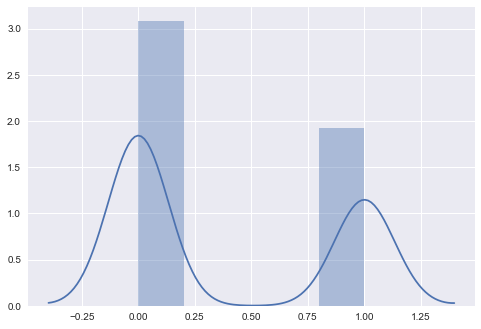

In [12]:
#Y_dist=pd.DataFrame(Y.label.value_counts())
#Y_dist = Y_dist.reset_index()
#Y_dist.columns = ['label','count']
#Y_dist = Y_dist.set_index('label').sort_index().reset_index()
sns.distplot(Y);

Take a look at each atrributes distribution.

In [20]:
#Divide Numerical and Categorical attributes
num_attri = ['PassengerId','Survived','Pclass','Age','sibsp','parch','Fare']
cat_attri = [column for column in train if column not in num_attri]
#print(num_attri)
#print(cat_attri)
#for column in train:
    #print(column)
    #check_str=train[column].str.contains('Mel').sum()
    #sns.distplot(train[column])

['PassengerId', 'Survived', 'Pclass', 'Age', 'sibsp', 'parch', 'Fare']
['Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked']
